# **Neural Network 기반 언어 모델**

(1990) Jeffrey L. Elman, Finding Structure in Time

https://onlinelibrary.wiley.com/doi/abs/10.1207/s15516709cog1402_1


(2010) Mikolov et al, Recurrent neural network based language model

https://onlinelibrary.wiley.com/doi/abs/10.1207/s15516709cog1402_1


(2014) Sutskever et al, Sequence to Sequence Learning with Neural Networks

https://arxiv.org/abs/1409.3215


(2014) Sutskever et al, Learning Phrase Representations using RNN Encoder–Decoder for Statistical Machine Translation

http://emnlp2014.org/papers/pdf/EMNLP2014179.pdf


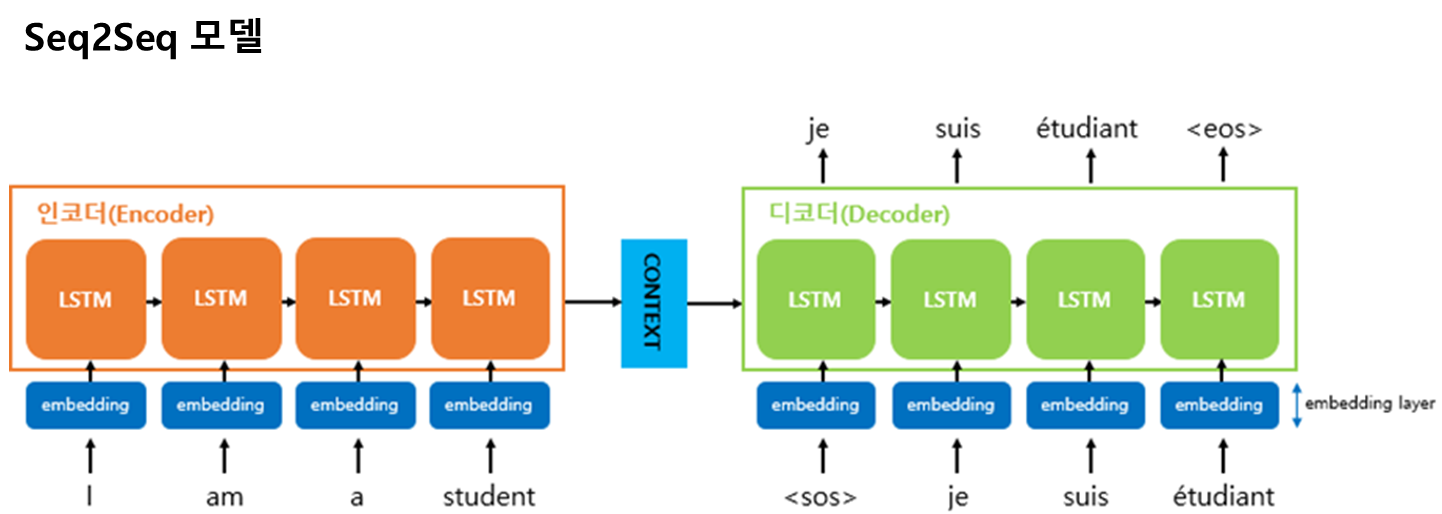

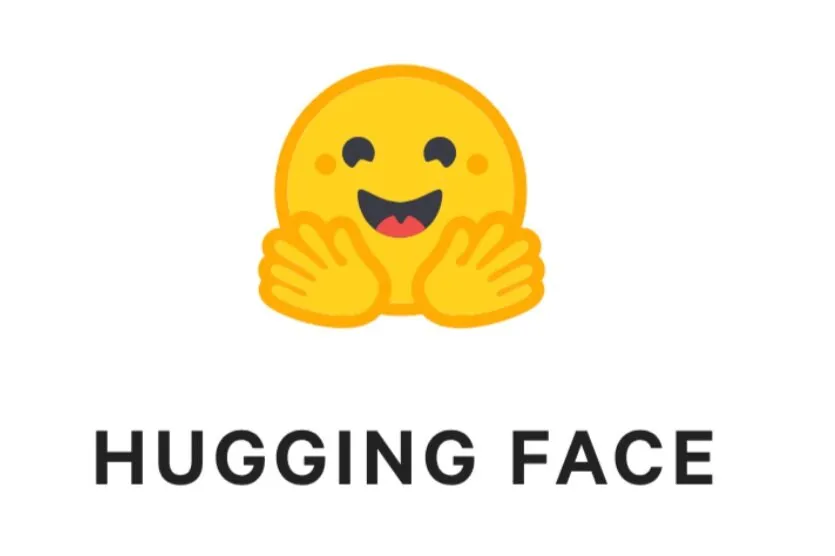

# **https://huggingface.co/**

In [ ]:
pip install datasets

In [ ]:
from datasets import load_dataset

dataset = load_dataset("Bingsu/laion-translated-to-en-korean-subset")
print(dataset)


In [ ]:
dataset['train']['TEXT'][:5]

In [ ]:
dataset['train']['ENG TEXT'][:5]

# **https://aihub.or.kr/**

https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=126

In [ ]:
pip install torch torchtext numpy matplotlib

In [ ]:
!wget "https://hycms.hanyang.ac.kr/index.php?module=xn_media_content2013&act=dispXn_media_content2013DownloadContent&content_id=67395feb6aaac" -O "korean_english_data.txt"

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from collections import Counter
import re

# 데이터 로딩 함수
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = file.readlines()
    return data

# 텍스트 전처리 함수
def preprocess_text(text):
    # 간단한 텍스트 전처리: 특수문자 제거, 소문자화
    text = re.sub(r"[^\w\s]", "", text.lower())
    return text

# 토큰화 및 데이터 전처리
def tokenize_data(data):
    src_sentences = []
    trg_sentences = []
    for line in data:
        src, trg = line.strip().split('\t')
        src_sentences.append(preprocess_text(src).split())
        trg_sentences.append(preprocess_text(trg).split())
    return src_sentences, trg_sentences

# 데이터 파일 경로
file_path = 'korean_english_data.txt'

# 데이터 로딩 및 전처리
data = load_data(file_path)
data = data[:10000]
src_sentences, trg_sentences = tokenize_data(data)

print("\n".join(data[:5]))

print("\nsrc_sentences")
print("\n".join(src_sentences[1]))

print("\ntrg_sentences")
print("\n".join(trg_sentences[1]))

# **토크나이저**

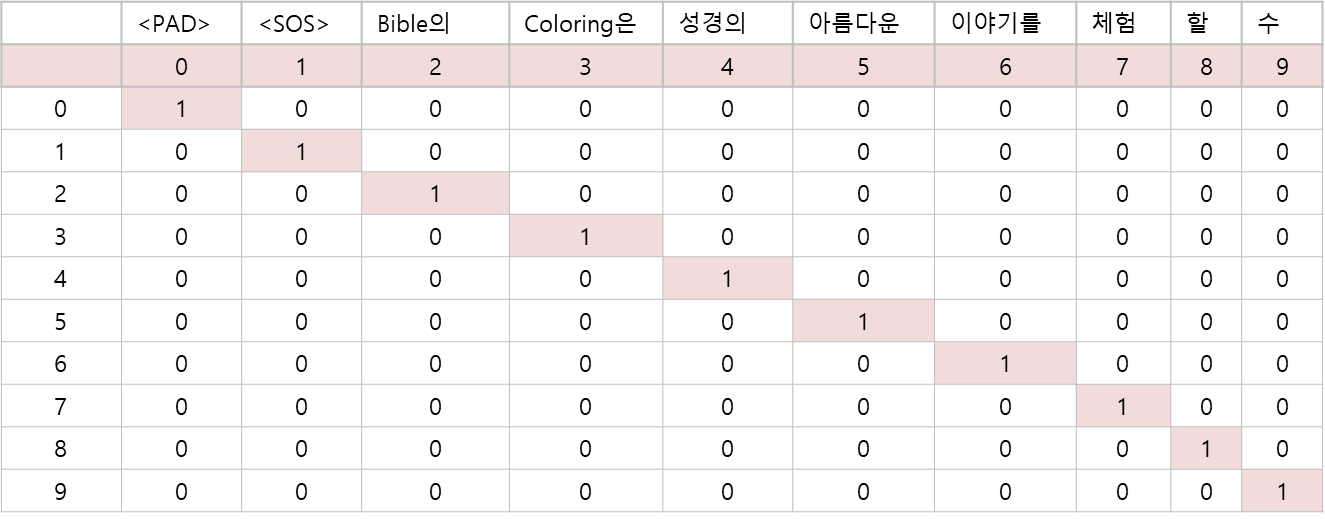

In [ ]:
# 단어 집합 구축
def build_vocab(sentences):
    word_counts = Counter()
    for sentence in sentences:
        word_counts.update(sentence)
    vocab = {word: idx for idx, (word, _) in enumerate(word_counts.items(), start=2)}
    vocab['<PAD>'] = 0
    vocab['<SOS>'] = 1
    vocab['<EOS>'] = len(vocab)
    return vocab

# 한국어와 영어 어휘 생성
src_vocab = build_vocab(src_sentences)
trg_vocab = build_vocab(trg_sentences)

# 단어 -> 인덱스, 인덱스 -> 단어 매핑
src_vocab_rev = {idx: word for word, idx in src_vocab.items()}
trg_vocab_rev = {idx: word for word, idx in trg_vocab.items()}

print("src_vocab : " + str(len(src_vocab)) + "\ntrg_vocab : " + str(len(trg_vocab)))

In [ ]:
# prompt: src_vocab  인덱스 순서대로 10개만 출력

print(list(src_vocab.keys())[:10])

In [ ]:
# prompt: src_vocab  인덱스 순서대로 10개만 출력

print(list(trg_vocab.keys())[:10])

In [ ]:
# prompt: src_vocab 에서 가장 많이 나오는 단어 10게 출력

from collections import Counter

# src_vocab에서 가장 많이 나오는 단어 10개 출력
word_counts = Counter()
for sentence in src_sentences:
    word_counts.update(sentence)

most_common_words = word_counts.most_common(10)
print("src_vocab에서 가장 많이 나오는 단어 10개:")
for word, count in most_common_words:
    print(f"{word}: {count}")

In [ ]:
# trg_vocab에서 가장 많이 나오는 단어 10개 출력
word_counts = Counter()
for sentence in trg_sentences:
    word_counts.update(sentence)

most_common_words = word_counts.most_common(10)
print("trg_vocab에서 가장 많이 나오는 단어 10개:")
for word, count in most_common_words:
    print(f"{word}: {count}")

# **단어 > 토큰 인덱스로 변경**

In [ ]:

# 인덱스 변환 함수
def sentence_to_idx(sentence, vocab):
    return [vocab.get(word, vocab['<PAD>']) for word in sentence]

# 데이터 인덱스 변환
src_idx = [sentence_to_idx(sentence, src_vocab) for sentence in src_sentences]
trg_idx = [sentence_to_idx(sentence, trg_vocab) for sentence in trg_sentences]

# 데이터셋 클래스 정의
class Seq2SeqDataset(Dataset):
    def __init__(self, src_data, trg_data):
        self.src_data = src_data
        self.trg_data = trg_data

    def __len__(self):
        return len(self.src_data)

    def __getitem__(self, idx):
        return torch.tensor(self.src_data[idx]), torch.tensor(self.trg_data[idx])

# 데이터 로더 생성
batch_size = 32
dataset = Seq2SeqDataset(src_idx, trg_idx)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(dataset.__len__())

In [ ]:
print(src_idx[0])
print(src_sentences[0])

In [ ]:
print(trg_idx[0])
print(trg_sentences[0])

# **모델 작성**

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        embedded = self.embedding(x)
        out, hidden = self.rnn(embedded)
        return out, hidden

print(Encoder(len(src_vocab), 256, 2))

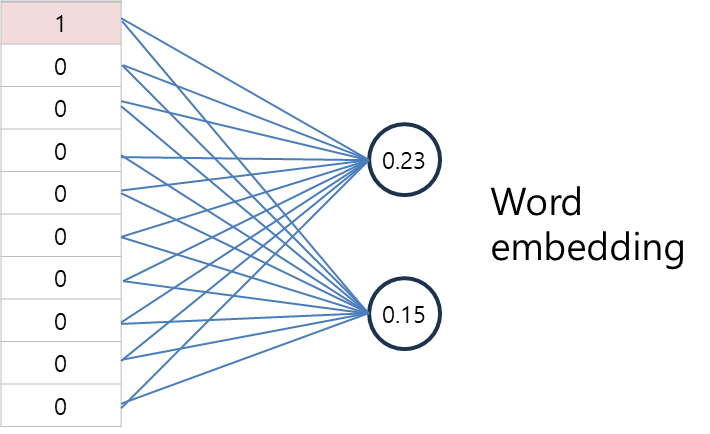

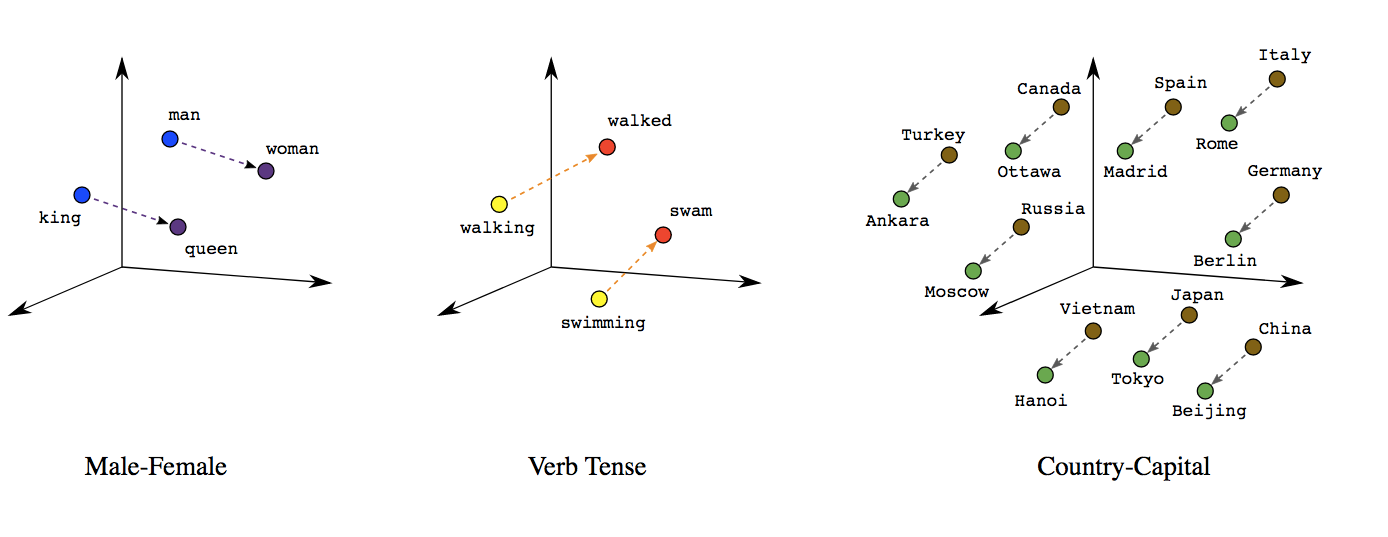

In [ ]:

class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size, num_layers):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        embedded = self.embedding(x)
        out, hidden = self.rnn(embedded, hidden)
        out = self.fc(out)
        return out, hidden


print(Decoder(len(trg_vocab), 256, 2))


In [ ]:

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # 인코더 출력
        encoder_out, encoder_hidden = self.encoder(src)

        # 디코더 초기 입력 (SOS 토큰)
        decoder_input = torch.ones(src.size(0), 1).long().to(src.device)  # <SOS> 토큰

        decoder_hidden = encoder_hidden
        outputs = []

        # 디코더 출력 생성
        for t in range(trg.size(1)):
            output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs.append(output)

            # Teacher Forcing 사용
            if random.random() < teacher_forcing_ratio:
                decoder_input = trg[:, t].unsqueeze(1)
            else:
                decoder_input = output.argmax(2)

        return torch.cat(outputs, dim=1)

print(Seq2Seq(Encoder(len(src_vocab), 256, 2), Decoder(len(trg_vocab), 256, 2)))

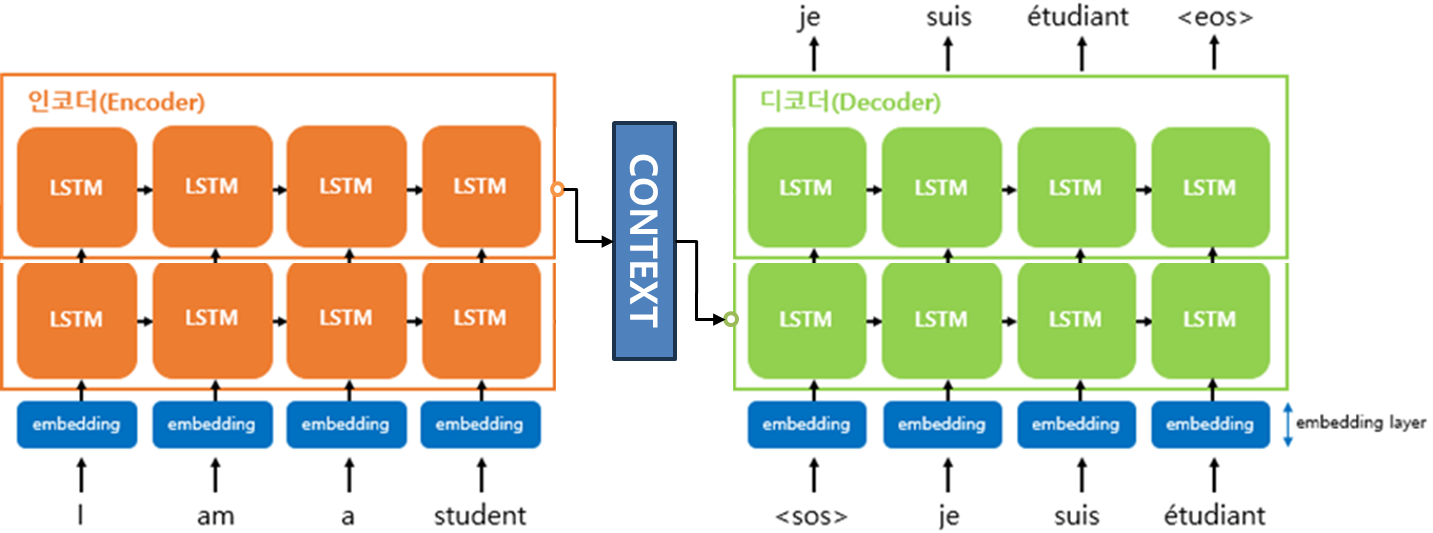

In [ ]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch
import random


# 모델 초기화
input_size = len(src_vocab)
output_size = len(trg_vocab)
hidden_size = 256
num_layers = 2

encoder = Encoder(input_size, hidden_size, num_layers)
decoder = Decoder(output_size, hidden_size, num_layers)
model = Seq2Seq(encoder, decoder).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# 손실 함수 및 옵티마이저
criterion = nn.CrossEntropyLoss(ignore_index=src_vocab['<PAD>'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Custom collate function to pad sequences to the same length
def collate_fn(batch):
    src, trg = zip(*batch)

    # Pad sequences to the same length
    src_padded = pad_sequence(src, batch_first=True, padding_value=src_vocab['<PAD>'])
    trg_padded = pad_sequence(trg, batch_first=True, padding_value=trg_vocab['<PAD>'])

    return src_padded, trg_padded

# Create DataLoader with the custom collate_fn
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)



In [ ]:
# Training loop
for epoch in range(10):  # 10 epoch 학습 예시
    model.train()
    total_loss = 0
    for i, (src, trg) in enumerate(dataloader):
        src = src.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        trg = trg.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        # 모델 예측
        optimizer.zero_grad()
        output = model(src, trg[:, :-1])  # <EOS> 토큰 제외

        # 손실 계산
        loss = criterion(output.view(-1, output.size(-1)), trg[:, 1:].contiguous().view(-1))  # <SOS> 제외
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch [{epoch+1}/10], Loss: {total_loss/len(dataloader):.4f}')


In [ ]:
!wget "https://hycms.hanyang.ac.kr/index.php?module=xn_media_content2013&act=dispXn_media_content2013DownloadContent&content_id=673a10d62a4f4" -O "data.zip"
!unzip  -O cp949 "data.zip" -d "data"

In [ ]:
import pickle

# 모델 로드
def load_model(model, optimizer, filepath):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, optimizer, epoch, loss

# 토크나이저 로드
def load_tokenizer(filepath):
    with open(filepath, 'rb') as f:
        src_vocab, trg_vocab = pickle.load(f)
    return src_vocab, trg_vocab

model, optimizer, epoch, loss = load_model(model, optimizer, 'data/model_checkpoint.pth')
print(f"Loaded model from epoch {epoch} with loss {loss}")

src_vocab, trg_vocab = load_tokenizer('data/tokenizer.pkl')
print(f"Loaded tokenizer with {len(src_vocab)} source tokens and {len(trg_vocab)} target tokens")

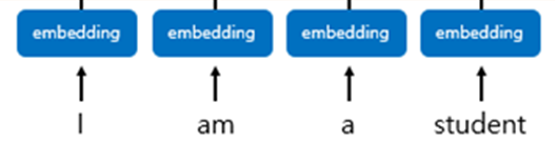

In [ ]:
def get_embedding_for_token(model, token, vocab):
    """
    Gets the embedding for a given token from the model's embedding layer.
    """
    try:
        token_index = vocab[token]
    except KeyError:
        print(f"Token '{token}' not found in vocabulary.")
        return None

    # Get the embedding layer (assuming your encoder has an embedding layer)
    embedding_layer = model.encoder.embedding

    # Create a tensor with the token index
    token_index_tensor = torch.tensor([token_index], dtype=torch.long, device=next(model.parameters()).device)

    # Get the embedding
    embedding = embedding_layer(token_index_tensor)
    return embedding

# Example usage:
token_to_find = "대한민국"
embedding = get_embedding_for_token(model, token_to_find, src_vocab) # assuming 대한민국 is in source vocab

if embedding is not None:
    print(f"Embedding for '{token_to_find}':\n{embedding}")

In [ ]:
# prompt: "대한민국"과 "한국", "우리나라", "남한", "북한"의 임베딩을 구하고 상호 cos유사도를 계산하요 표러 표시

import pandas as pd
import numpy as np
# from sklearn.metrics.pairwise import cosine_similarity

# Sample embeddings (replace with actual embeddings from your model)
embeddings = {
    "대한민국": get_embedding_for_token(model, "대한민국", src_vocab),  # Example 10-dimensional embedding
    "일본": get_embedding_for_token(model, "일본", src_vocab),
    "북한":  get_embedding_for_token(model, "북한", src_vocab),
    "한국":  get_embedding_for_token(model, "한국", src_vocab),
    "우리나라":  get_embedding_for_token(model, "우리나라", src_vocab),
}


# Process other embeddings
for word, emb in embeddings.items():
    if emb is not None:
        emb_np = emb.cpu().detach().numpy()
        embeddings[word] = emb_np


In [ ]:
import numpy as np

def cosine_similarity(vec1, vec2):
    """Calculate the cosine similarity between two vectors."""
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    return dot_product / (norm1 * norm2)

# 단어 리스트와 벡터 리스트
words = list(embeddings.keys())
vectors = list(embeddings.values())


# 유사도 계산
similarity_matrix = np.zeros((len(words), len(words)))

for i in range(len(vectors)):
    for j in range(len(vectors)):
        similarity_matrix[i, j] = cosine_similarity(vectors[i].reshape(256), vectors[j].reshape(256))

# 출력
print("단어 간 유사도 행렬:")
print(similarity_matrix)

# 데이터프레임 형식으로 보기 좋게 출력 (선택 사항)
import pandas as pd

df = pd.DataFrame(similarity_matrix, index=words, columns=words)
print("\n유사도 행렬 (데이터프레임):")
print(df)


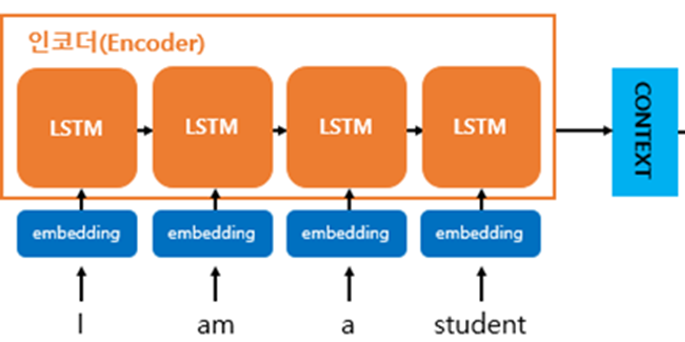

In [ ]:
def get_context(model, src_sentence, src_vocab):
    model.eval()
    src_idx = sentence_to_idx(src_sentence.split(), src_vocab)
    src_tensor = torch.tensor([src_idx]).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    # 인코더에서 출력 받기
    with torch.no_grad():
        encoder_out, encoder_hidden = model.encoder(src_tensor)

    return encoder_out


src_sentence = "나는 학생이다."
context_vector = get_context(model, src_sentence, src_vocab)

print(context_vector)

In [ ]:

# Sample embeddings (replace with actual embeddings from your model)
embeddings = {
    "나는 학생이다.": get_context(model, "나는 학생이다.", src_vocab),  # Example 10-dimensional embedding
    "너는 학생이다":  get_context(model, "너는 학생이다", src_vocab),
    "나는 누구인가":  get_context(model, "나는 누구인가", src_vocab),
}


# Process other embeddings
for word, emb in embeddings.items():
    if emb is not None:
        emb_np = emb.cpu().detach().numpy()
        embeddings[word] = emb_np


In [ ]:
import numpy as np

def cosine_similarity(vec1, vec2):
    """Calculate the cosine similarity between two vectors."""
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    return dot_product / (norm1 * norm2)

# 단어 리스트와 벡터 리스트
words = list(embeddings.keys())
vectors = list(embeddings.values())


# 유사도 계산
similarity_matrix = np.zeros((len(words), len(words)))

for i in range(len(vectors)):
    for j in range(len(vectors)):
        similarity_matrix[i, j] = cosine_similarity(vectors[i].reshape(512), vectors[j].reshape(512))

# 출력
print("단어 간 유사도 행렬:")
print(similarity_matrix)

# 데이터프레임 형식으로 보기 좋게 출력 (선택 사항)
import pandas as pd

df = pd.DataFrame(similarity_matrix, index=words, columns=words)
print("\n유사도 행렬 (데이터프레임):")
print(df)


In [ ]:
def translate(model, src_sentence, src_vocab, trg_vocab_rev):
    model.eval()
    src_idx = sentence_to_idx(src_sentence.split(), src_vocab)
    src_tensor = torch.tensor([src_idx]).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    # 인코더에서 출력 받기
    with torch.no_grad():
        encoder_out, encoder_hidden = model.encoder(src_tensor)

    decoder_input = torch.tensor([[trg_vocab['<SOS>']]]).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    decoder_hidden = encoder_hidden
    translated_sentence = []

    # 디코더에서 출력 생성
    for _ in range(50):  # 최대 50단어 예측
        output, decoder_hidden = model.decoder(decoder_input, decoder_hidden)
        top1 = output.argmax(2)
        translated_sentence.append(trg_vocab_rev[top1.item()])
        decoder_input = top1

        if top1.item() == trg_vocab['<EOS>']:
            break

    return ' '.join(translated_sentence)

# 예시 번역
src_sentence = "나는 학생이다."
translated_sentence = translate(model, src_sentence, src_vocab, trg_vocab_rev)
print(f'Source Sentence: {src_sentence}')
print(f'Translated Sentence: {translated_sentence}')


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# prompt: 학습이 완료된 모델의 가중치를 저장하고 다시 로드하는 코드 만들어줘

# 모델 저장
def save_model(model, optimizer, epoch, loss, filepath):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, filepath)


# 모델 저장 예시 (학습 루프 내에서 적절한 시점에 호출)
save_model(model, optimizer, epoch, loss, '/content/drive/MyDrive/Colab Notebooks/model_checkpoint.pth')

# 모델 로드 예시
# model, optimizer, epoch, loss = load_model(model, optimizer, 'model_checkpoint.pth')
# print(f"Loaded model from epoch {epoch} with loss {loss}")


In [ ]:
# prompt: 토크나이저도 저장했다가 다시 불러낼 수 있게 해줘


# 토크나이저 저장
def save_tokenizer(src_vocab, trg_vocab, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump((src_vocab, trg_vocab), f)


# 토크나이저 저장 예시
save_tokenizer(src_vocab, trg_vocab, '/content/drive/MyDrive/Colab Notebooks/tokenizer.pkl')

# 토크나이저 로드 예시
# src_vocab, trg_vocab = load_tokenizer('tokenizer.pkl')
# print(f"Loaded tokenizer with {len(src_vocab)} source tokens and {len(trg_vocab)} target tokens")